### First ideas:
On the abalone.csv file we'll:
- Plot the dataset through PCA reduction
- Inject errors
- Try median/mode and MICE with K-NN with median/mode
- Re-plot the dataset to see how it changed

### General imports and definitions

['0', '1', '2', '3', '4', '5', '6', '7']


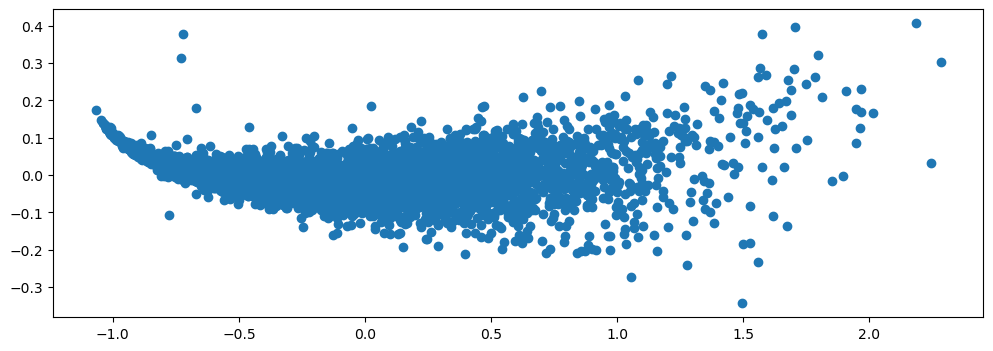

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from dirty_completeness import injection

# Load the dataset
df = pd.read_csv("../datasets/abalone.csv")
missing_columns = list(df.columns)  # after quick inspection we see that all columns will contain missing values
print(missing_columns)

# PCA visualization
fig, ax = plt.subplots(figsize=(12,4))

pca = PCA(n_components=2,random_state=42)
X_pca = pca.fit_transform(df.drop('0',axis = 1))  # categorical features are dropped to allow visualization

ax.scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()

In [2]:
# Obtain the list of null-injected datasets
perc = [0.50, 0.40, 0.30, 0.20, 0.10]
df_list = injection(df, 42, "abalone", "None")

print("\nMissing values per column for each version:")
for ds in df_list:
    print(list(ds.isnull().sum()))

saved abalone-completeness50%
saved abalone-completeness60%
saved abalone-completeness70%
saved abalone-completeness80%
saved abalone-completeness90%

Missing values per column for each version:
[2082, 2149, 2107, 2102, 2008, 2022, 2134, 2081]
[1704, 1672, 1674, 1732, 1625, 1633, 1690, 1656]
[1215, 1244, 1273, 1241, 1266, 1280, 1316, 1252]
[836, 823, 862, 868, 834, 873, 836, 815]
[402, 416, 406, 379, 404, 425, 424, 399]


### Single imputation: mode
Since we also have categorical features it is better to use the mode instead of the median, otherwise it would be difficult to define an ordinal order between the categorical values

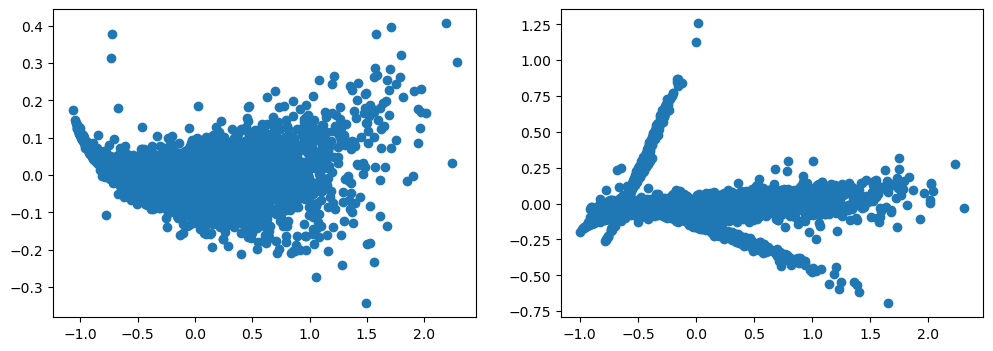

In [3]:
test_ind = 4  # must be between 0 and 4
df_test = pd.DataFrame(columns = [name for name in missing_columns])
for col in missing_columns:
    df_test[col] = df_list[test_ind][col].fillna(df_list[test_ind][col].mode()[0])

# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(12,4))

pca = PCA(n_components=2,random_state=42)

X_pca = pca.fit_transform(df.drop('0',axis = 1))
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])

X_pca = pca.fit_transform(df_test.drop('0',axis = 1))
axes[1].scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()

### MICE - Multiple Imputation by Chained Equations
Once again, the presence of categorical features represents a problem. We can think about 2 possible approaches:
- One-hot encode the categorical feature and try base MICE on the new dataset
- Use base MICE on the numerical features only and train a classifier (logistic regression or k-neighbors) to make inputation on the categorical feature values

We can try both

#### First approach: one-hot encoding


In [4]:
import math

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor

test_ind = 0  # must be between 0 and 4

df_cat = df_list[test_ind]['0']
df_num = df_list[test_ind].drop('0',axis = 1)

df_cat_oh = []
for row in df_cat:
    temp = np.zeros((3, ))
    if row == 'M':
        temp[0] = 1
    elif row == 'I':
        temp[1] = 1
    elif row == 'F':
        temp[2] = 1
    elif math.isnan(row):
        temp = np.full((3, ), np.nan)
    df_cat_oh.append(temp)
    
df_cat = pd.DataFrame(df_cat_oh, columns = ['M', 'I', 'F'])
df_c = df_cat.join(df_num)
df_c

,M,I,F,1,2,3,4,5,6,7
0,NaN,NaN,NaN,0.455,NaN,0.095,0.5140,NaN,0.1010,NaN
1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0995,NaN,0.070
2,0.0,0.0,1.0,NaN,NaN,NaN,0.6770,NaN,0.1415,NaN
3,1.0,0.0,0.0,NaN,0.365,NaN,NaN,0.2155,NaN,0.155
4,NaN,NaN,NaN,0.330,NaN,0.080,NaN,NaN,NaN,0.055
...,...,...,...,...,...,...,...,...,...,...
4172,NaN,NaN,NaN,0.565,NaN,0.165,NaN,NaN,0.2390,0.249
4173,1.0,0.0,0.0,0.590,NaN,0.135,0.9660,0.4390,NaN,NaN
4174,1.0,0.0,0.0,NaN,0.475,NaN,1.1760,NaN,0.2875,NaN
4175,0.0,0.0,1.0,0.625,NaN,0.150,1.0945,NaN,NaN,NaN


In [5]:
multivariate_impute_pipe = ColumnTransformer([("impute_num", 
                                                IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=10),max_iter=100), 
                                                df_c.columns)]
                                            )
                                            
df_mice = multivariate_impute_pipe.fit_transform(df_c)
df_test = pd.DataFrame(df_mice, columns=df_c.columns)

c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


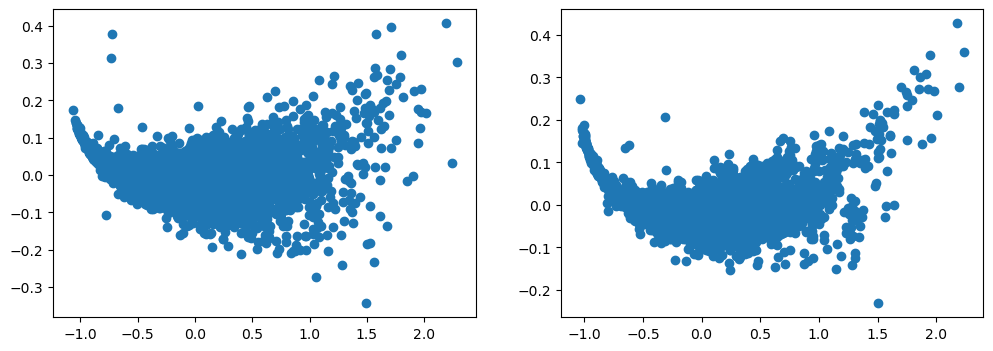

In [6]:
# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(12,4))

pca = PCA(n_components=2,random_state=42)

X_pca = pca.fit_transform(df.drop('0', axis = 1))
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])

X_pca = pca.fit_transform(df_test.drop(['M', 'I', 'F'], axis = 1))  # one-hot encoded categorical features are dropped to allow visual comparison
axes[1].scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()

#### Second approach: MICE on numerical + classifier on categorical
If we wish to use the same algorithm between the 2 datasets the previous approach should be preferred since the second dataset is composed only by categorical features, meaning that this method would be reduced to a ML-based imputation algorithm

In [19]:
import math

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor

test_ind = 4  # must be between 0 and 4

df_cat = df_list[test_ind]['0']
df_num = df_list[test_ind].drop('0',axis = 1)

# Apply MICE on df_num
multivariate_impute_pipe = ColumnTransformer([
                                            ("impute_num", 
                                            IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=10),max_iter=100), 
                                            df_num.columns)
                                            ])
                                            
df_mice = multivariate_impute_pipe.fit_transform(df_num)

# Prepare the matrixes for the classifier (since NaN targets will be ignored, the accuracy of the classifier will depend on the percentage of missing values)
y = []
X = []
for t, x in zip(df_cat, df_mice):
    if t == 'M':
        y.append(0.)
        X.append(x)
    elif t == 'I':
        y.append(1.)
        X.append(x)
    elif t == 'F':
        y.append(2.)
        X.append(x)
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(3775, 7) (3775,)


c:\Users\tomma\anaconda3\envs\diq\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [20]:
# Train the classifier
from sklearn.neighbors import KNeighborsClassifier  # we can also try other kinds of classifiers

classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X, y)

# Use the classifier to predict only missing targets (the categorical values)
df_cat_list = []
for t, x in zip(df_cat, df_mice):
    if t == 'M' or t == 'I' or t == 'F':
        df_cat_list.append(t)
    else:
        df_cat_list.append(classifier.predict(x.reshape(1, -1)))

# Get back to the categorical values
df_cat_imp = []
for t in df_cat_list:
    if t == 0.:
        df_cat_imp.append('M')
    elif t == 1.:
        df_cat_imp.append('I')
    elif t == 2.:
        df_cat_imp.append('F')

# Recompose the dataset
df_mice = pd.DataFrame(df_mice, columns=df_num.columns)
df_cat_imp = pd.DataFrame(df_cat_imp, columns=['0'])
df_test = df_cat_imp.join(df_mice)

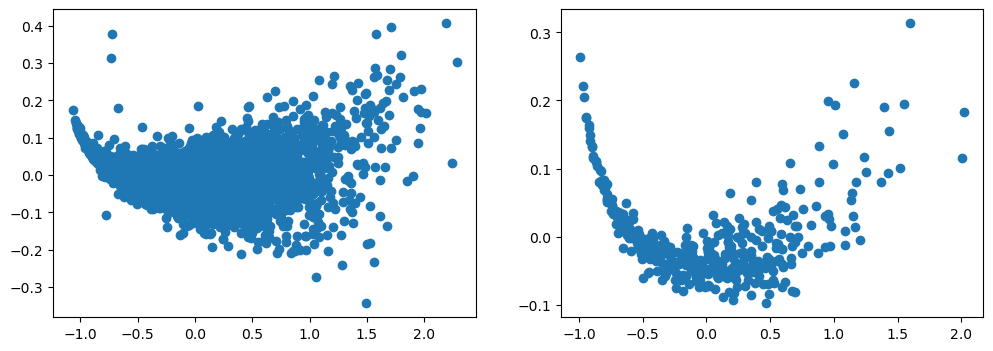

In [21]:
# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(12,4))

pca = PCA(n_components=2,random_state=42)

X_pca = pca.fit_transform(df.drop('0', axis = 1))
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])

X_pca = pca.fit_transform(df_test.drop('0', axis = 1))  # categorical features are dropped to allow visual comparison
axes[1].scatter(X_pca[:, 0], X_pca[:, 1])

plt.show()

Strangely, this approach seems to work better when the percentage of missing values is higher: in any case it seems to work less well than the first one, so the only thing we can do is to use the first or try another kind of classifier